# ***DITTOBREEDO*** 
## My Pokemon Deep Convolutional Generative Adversarial Network (DCGAN)

# Library Imports
- Make sure libraries are installed with pip in virtual env.
- Can use requirements.txt to do that, although it's not the best way (probably dependency clashes)
- Best to `pip install` all libraries listed here and dependencies will be managed automatically

In [174]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import PIL
from tensorflow.keras import layers
import time
import cv2

from IPython import display

# ETL (Load and prepare the dataset)

## Optimising performance + preprocessing functions
- `preprocess`: called with ***map*** on dataset of filenames to extract image, normalise and load into new dataset.
- `configure_for_performance`: performs dataset optimisation by caching, prefetching, suffling and preparing dataset into specified batches

In [175]:
def preprocess(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # load the image as uint8 array and transform to grayscale
    if IMAGE_CHANNELS ==4:
        img = tf.io.decode_png(img, channels=IMAGE_CHANNELS)
    else:
        img = tf.io.decode_jpeg(img, channels=IMAGE_CHANNELS)
    # resize the image to the desired size
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    # transform the color values from [0, 255] to [-1, 1]. The division changes the datatype to float32
    img = (img - 127.5) / 127.5    
    return img

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

## Additional dataset transformations
- Declare important global notebook variables
- Get directory of images and load file names into dataset
- Call on the `preprocess` and `configure_for_performance` to prepare the dataset (fastest way I have ever tried with image data)

In [176]:
IMAGE_CHANNELS = 3
IMAGE_SIZE = 256
BATCH_SIZE = 4
BUFFER_SIZE = 1000
EPOCHS = 400
LATENT_SPACE_DIM = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, LATENT_SPACE_DIM])

# pokemon_images_path = str('J:/Keravnos_X-files/CS/datasets/pokemon/archive/pokemon/pokemon/*')
pokemon_images_path = str('J:/Keravnos_X-files/CS/datasets/pokemon/archive/pokemon_jpg/pokemon_jpg/*')


list_ds = tf.data.Dataset.list_files(pokemon_images_path, shuffle=True)  # Get all images from subfolders
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_dataset = list_ds.take(-1)
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = configure_for_performance(train_dataset)

# CREATE THE **G** AND **D**

### The Generator (G)

- The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise).
- Starts with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size.
- I wanted to capture as much detail as possible at the cost of performance so I keep the original size and dimensions of images so its either 256x256x3 or 256x256x4 (depending on img format)
- Notice the pattern of convolution/batchNorm/activation is used with decreasing kernel size
- Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [177]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    neurons = IMAGE_SIZE // 4
    
    model.add(layers.Dense(neurons * neurons * 256, use_bias=False, input_shape=(LATENT_SPACE_DIM,)))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((neurons, neurons, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())
    # model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.truncated_normal_initializer(
    #         stddev=0.02)))
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    print('G OUTPUT SHAPE:', model.output.shape)
    return model

### The Discriminator (D)

- The discriminator is a simple CNN-based image classifier.
- Not the best or most optimised but we need to keep G and D at a similar performance level
- I like to use `GaussianNoise` for some additional regularisation other than `Dropout`
- I have tested 0.2 and 0.3 `Dropout` (I think 0.5 is too much). Hard to say which is best. Have to investigate more with metrics in `HPARAMS` to come to a conclusion 

In [178]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.GaussianNoise(0.2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.GaussianNoise(0.2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.GaussianNoise(0.2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.GaussianNoise(0.2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Define the loss and optimizers for D and G

### Discriminator loss

- This method quantifies how well the discriminator is able to distinguish real images from fakes.
- It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [179]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

- The generator's loss quantifies how well it was able to trick the discriminator.
- Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
- Here, compare the discriminators decisions on the generated images to an array of 1s.

In [180]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- The discriminator and the generator optimizers need to have an instance each, since you will train two networks separately.
- We choose Adam as it is generally performing very well in most scenarios.

In [181]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator = make_discriminator_model()
generator = make_generator_model()

G OUTPUT SHAPE: (None, 256, 256, 3)


# TRAINING

## Define the training loop functions
- The training loop begins with generator receiving a random seed as input. 
- That input seed is used to generate an image by G.
- D then attempts to classify real images (drawn from the training set) and fakes images (produced by G). 
- The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
- Notice that images pass through data augmentation processes randomly to diversify the data. These augmentations include `LR_FLip`, `Brightness`, `Contrast`, `Hue`
- Can consider a better set of augmentations in the future to better diversify as `Brightness`, `Contrast` might not contribute much.

In [182]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_SPACE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # training=True is important, since Dropout and BatchNorm behave differently during inference
        generated_images = generator(noise, training=True)
 
        ### data aug start ###
        image = tf.image.random_flip_left_right(images)
        image = tf.image.random_brightness(images, max_delta = 0.1)
        image = tf.image.random_contrast(images, lower = 0.9, upper = 1.1)
        image = tf.image.random_hue(images, 0.2)
        ### data aug ends ###
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        # Return stats
        return disc_loss, gen_loss

In [183]:
def train(dataset, epochs, save_after):
    # Track losses and scores
    disc_losses = []
    gen_losses = []
    
    generate_and_save_images(generator, 0, seed)

    for epoch in tqdm.tqdm(range(epochs),'Epochs'):
        start = time.time()
        for image_batch in dataset:
            disc_loss, gen_loss = train_step(image_batch)
            
            # Collect results
            disc_losses.append(disc_loss)
            gen_losses.append(gen_loss)
            
        if (epoch + 1) % save_after == 0:
            # Produce images for the GIF as we go
            checkpoint.save(file_prefix = checkpoint_prefix)
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    return disc_losses, gen_losses

## Generate and save images
- This function is the bread and butter of subjective quality control.
- Generates predictions and plots them when called.
- Saves a png image with the ***epoch*** and ***batch size*** in its name.

In [184]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(24, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 8, i + 1)
        if predictions.shape[-1] == 3:
            plt.imshow(predictions[i] * 0.5 + .5)  # scale image to [0, 1] floats (or you could also scale to [0, 255] ints) 
        else: 
            plt.imshow(predictions[i, :, :, 0] * 0.5 + .5)  # scale image to [0, 1] floats (or you could also scale to [0, 255] ints)
        
    plt.suptitle(f'Epoch {epoch}')
    plt.savefig('./output_imgs/image_at_epoch_{:04d}_and_BS_{}.png'.format(epoch,BATCH_SIZE))
    plt.show()

### Save checkpoints
Save and restore models (Can be helpful in case a long running training task is interrupted, or you want to export model for further use elsewhere (external reconstruction))

In [185]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Train the model
- Call the `train()` method defined above to train the generator and discriminator simultaneously.
- Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).
- At the beginning of the training, the generated images look like random noise.
- As training progresses, the generated pokemon will look increasingly real (***subjective*** - this pokemon dataset is quite hard).
- This takes about 12-20 seconds per epoch on my PC with a `RTX2070 super`. Collab will be much slower. TPU Kaggle might be a better choice.

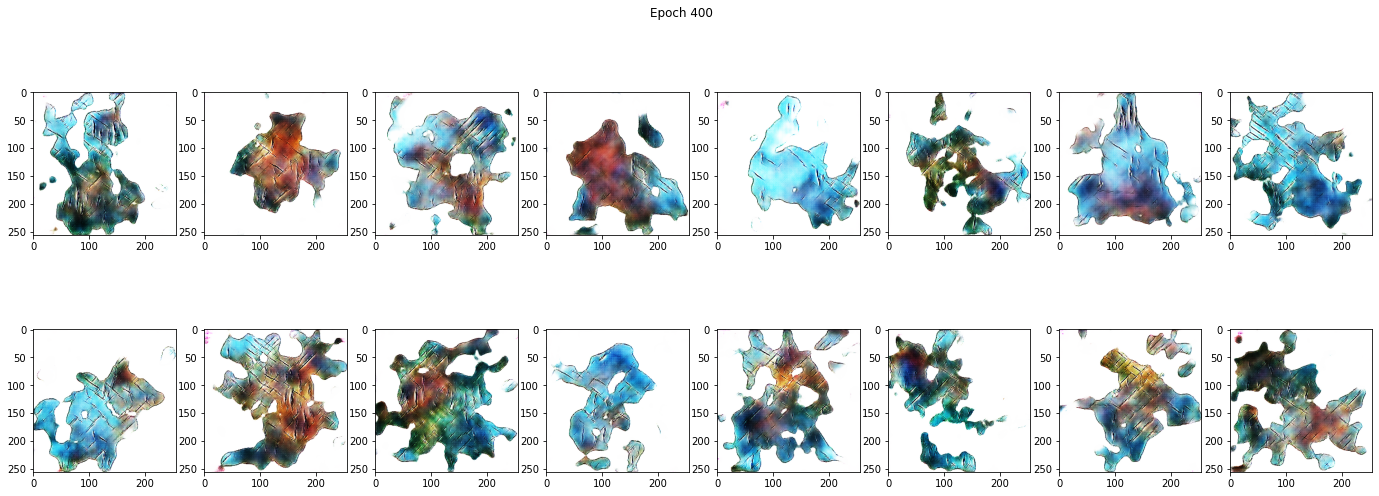

In [186]:
disc_losses, gen_losses = train(train_dataset, EPOCHS, 20)

# Create a GIF
- Using Tensorflow's tutorial for most of this notebook adapted from the MNIST dataset to the Pokemon dataset
- So I use the same method for producing a GIF showing the results of the GAN.

In [189]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('./output_imgs/image_at_epoch_{:04d}_and_BS_{}.png'.format(epoch_no,BATCH_SIZE))

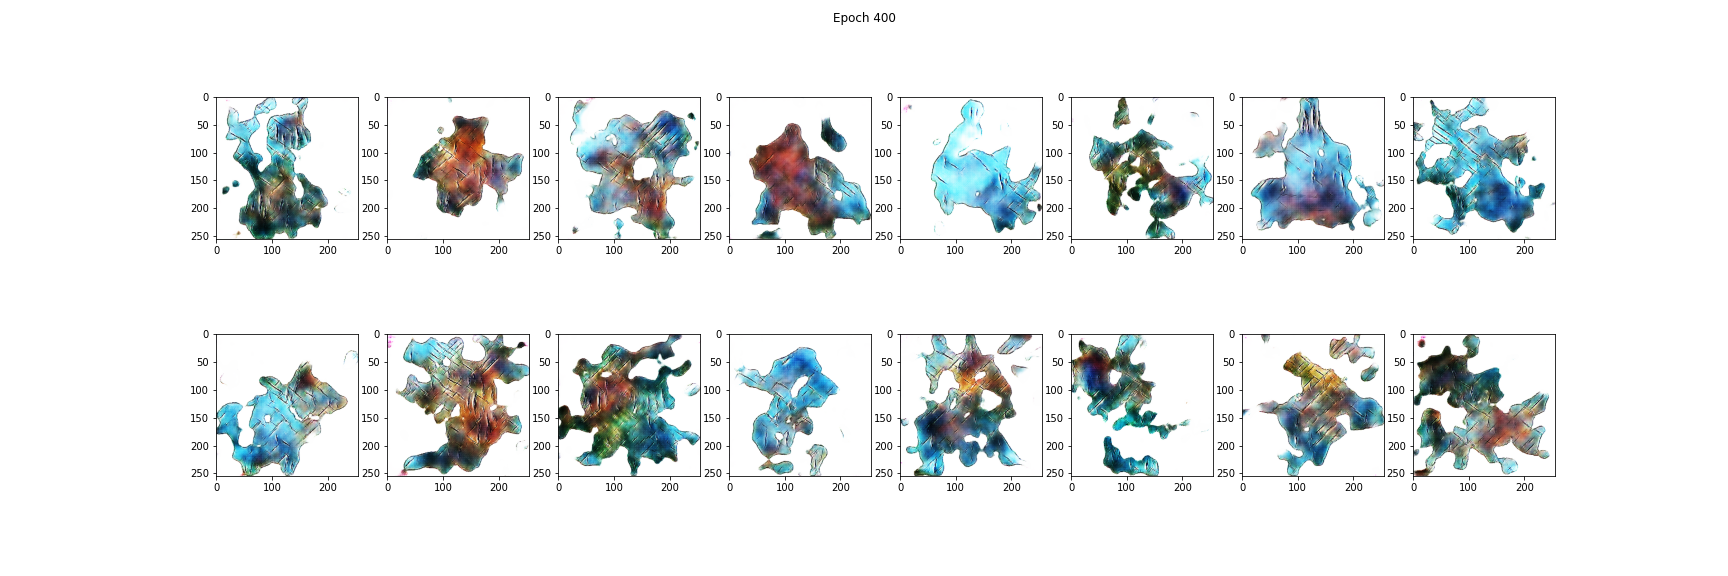

In [190]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.


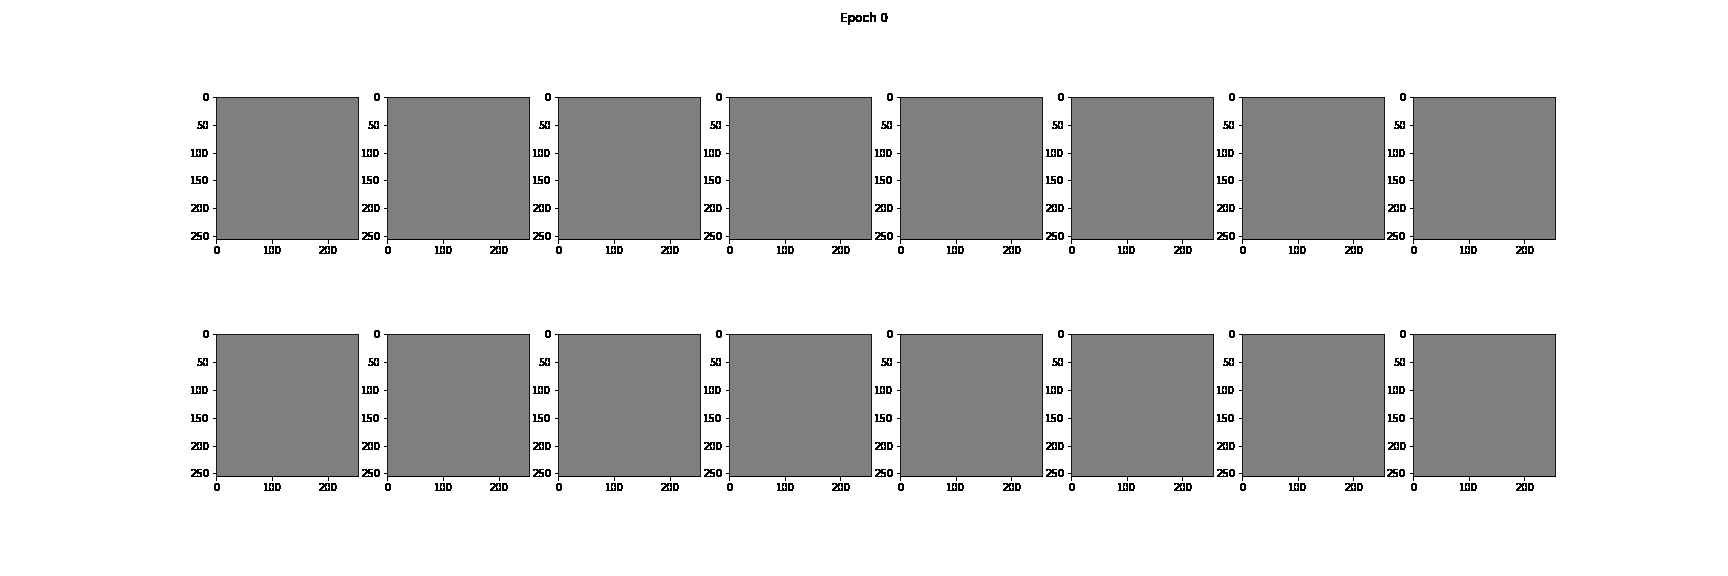

In [193]:
import tensorflow_docs.vis.embed as embed

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./output_imgs/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
embed.embed_file(anim_file)

# FUTURE PLANS

- Try different latent dimensions and batch sizes
- Log hyperparameters more efficiently for better tuning
- Refactor loss and accuracy monitoring for better export of metrics
- Monitor how D performs compared to G as I suspect G managed to fool D quite fast converging to a local minimum.
- To try and create more lifelike pokemon might consider `transfering` generator and using a  `CycleGAN` with an animal dataset?? (Don't know how that will turn out)